<a href="https://colab.research.google.com/github/Murolando/Naruto_characters_GAN_nn/blob/main/GANNaruto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение GAN модели, которая будет рисовать лица на подобие персонажей из Наруто

Задача заключается в том, чтобы обучиться GAN сеть рисовать лица как у персонажей мира Наруто.

Данные были взята с kaggle: [https://www.kaggle.com/datasets/neetuk/naruto-face-dataset]

In [9]:
import torch 
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import torchvision.transforms as transforms

from matplotlib.pyplot import figure
from torchvision.utils import save_image

# Для считывания картинок
from skimage.io import imread
import os
from PIL import Image
import io

from skimage.transform import resize

# Для вывода картинок 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision.utils as vutils
from IPython.display import HTML
import matplotlib.animation as animation

##Подргузим наши картиночки

In [ ]:
images = []

for root, dirs,files in os.walk('/content/drive/MyDrive/Deep learning /Gans по наруто лицам/photos/images-big'):
  
  for file in files:
    try:
      images.append(imread(os.path.join(root,file)))
    except:
      print(file)

In [ ]:
len(images)

3621

In [ ]:
images[0].shape

(127, 128, 3)

## Приведем их размер к одному виду

In [ ]:
size = (100, 100)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]

In [ ]:
X = np.array(X, np.float32)

In [ ]:
X[0].shape

(100, 100, 3)

In [ ]:
X[0]

array([[[0.7288824 , 0.677902  , 0.6033922 ],
        [0.7272353 , 0.67647725, 0.6033922 ],
        [0.7249608 , 0.6741392 , 0.60064703],
        ...,
        [0.35686275, 0.24811764, 0.23137255],
        [0.35686275, 0.24811764, 0.23137255],
        [0.35686275, 0.24766235, 0.23137255]],

       [[0.7223137 , 0.6713333 , 0.5968235 ],
        [0.72133374, 0.6713333 , 0.5968235 ],
        [0.7199804 , 0.6685882 , 0.5940784 ],
        ...,
        [0.35686275, 0.25490198, 0.23137255],
        [0.35686275, 0.25490198, 0.23137255],
        [0.35686275, 0.25152943, 0.23137255]],

       [[0.715     , 0.6640196 , 0.5895098 ],
        [0.7138882 , 0.6640196 , 0.5895098 ],
        [0.71235293, 0.6631274 , 0.5886176 ],
        ...,
        [0.35686275, 0.25490198, 0.23137255],
        [0.35686275, 0.25490198, 0.23137255],
        [0.35686275, 0.25152943, 0.23137255]],

       ...,

       [[0.6517078 , 0.60219413, 0.5183745 ],
        [0.6578235 , 0.6111373 , 0.5244902 ],
        [0.6628431 , 0

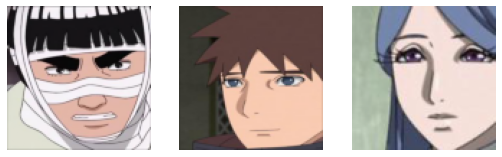

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6,9):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])
plt.show();

## Закинем все в даталоадер

In [ ]:
data_x = DataLoader(np.rollaxis(X, 3, 1),batch_size=32, shuffle=True)

In [ ]:
a = np.rollaxis(X, 3, 1)
a.shape

(3621, 3, 100, 100)

## Подлючаем gpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Архитектура Сети

Сама сеть выглядит следующим образом:
<img src ='https://habrastorage.org/r/w1560/getpro/habr/upload_files/c40/568/876/c40568876434c2bcc933c2a5b7d29725.jpeg'>

In [ ]:
# # custom weights initialization called on netG and netD
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

### Генератор

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.main = nn.Sequential(
            # 1 => 4
            nn.ConvTranspose2d(100,  512, 4, 1, 0, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=False),
            # 4 => 8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=False),
            # 8 => 16
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=False),
            # 16 => 32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            # 32 => 100
            nn.ConvTranspose2d( 64, 3, 7, 3, 0, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)
        # return self.oleg(x)


### Дискриминатор

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()


        self.main = nn.Sequential(
            
            nn.Conv2d(3, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            
            nn.Conv2d(64, 128, 4, 2, 1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(256, 512, 5, 2, 1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 5, 1, 0, bias=True),
            nn.Flatten(),
            nn.Sigmoid(),
        )
        self.end = nn.Sequential(
            nn.Sigmoid()
        )

    def forward(self, x):
        # x = self.main(x)
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # return self.end(x)
        return self.main(x)


## Обучение Сети 

### Инициализируем необходимые переменные для обучения

In [ ]:
img_list = []
hist_of_photo = torch.randn(10, 100, 1, 1, device=device)
# инциализируем веса моделей
# netD = Discriminator().to(device)
# netD.apply(weights_init)

# netG = Generator().to(device)
# netG.apply(weights_init)

In [ ]:
def train_model(netG, netD, lr, epochs, data_tr,G_losses,D_losses):
  criterion = nn.BCELoss()
  real_label = 1.
  fake_label = 0.

  # оптимизаторы для градиентного спуска
  optimizerD = optim.Adam(netD.parameters(), lr= lr)
  optimizerG = optim.Adam(netG.parameters(), lr= lr)

  for epoch in range(epochs):
    i = 0
    for X_batch in data_tr:
      i+=1

      # real images
      real_img = X_batch.to(device)
      # real_labels = torch.ones(len(X_batch),device = device)
      real_labels =  (0.7 - 1.2) * torch.rand(len(X_batch),device = device) + 1.2
     
      # fake images
      noise = torch.randn(len(X_batch), 100, 1, 1, device=device)
      fake_images = netG.forward(noise)
      fake_labels = torch.zeros(len(X_batch),device = device)
      fake_labels =  (0.0 - 0.3) * torch.rand(len(X_batch),device = device) + 0.3
      flipped_fake_labels = real_labels # для трюка какого то
      # ----------------------
      # Обучения  дискриминатора(классификатора)
      # ----------------------

      optimizerD.zero_grad()

      # discrim on real
      discr_pred_real = netD.forward(real_img).view(-1) # Nx1 -> N
      # print(discr_pred_real)
      real_loss = criterion(discr_pred_real,real_labels)
      # real_loss = torch.binary_cross_entropy_with_logits(discr_pred_real,real_labels)

      # discrim on fake
      discr_pred_fake = netD.forward(fake_images.detach()).view(-1) # Nx1 -> N
      fake_loss = criterion(discr_pred_fake,fake_labels)
      # fake_loss = torch.binary_cross_entropy_with_logits(discr_pred_fake,fake_labels)
      # comb loss
      discr_loss = 0.5*(real_loss+fake_loss)
      discr_loss.backward()

      optimizerD.step()

      # ----------------------
      # Обучения  генератора(создатель картинок)
      # ----------------------


      optimizerG.zero_grad()

      # get discrim loss on fake images with flipped labels
      discr_pred_fake = netD.forward(fake_images).view(-1)
      gener_loss = criterion(discr_pred_fake,flipped_fake_labels)
      gener_loss.backward()

      optimizerG.step()


      # ----------------------
      # Логи
      # ----------------------
      
      G_losses.append(gener_loss.item())
      D_losses.append(discr_loss.item())

    photos = netG.forward(hist_of_photo)
    img_list.append(photos)
    print(epoch,G_losses[-1],D_losses[-1])

  return netG

In [ ]:
G_losses = []
D_losses = []
discriminator = Discriminator().to(device)
generator = Generator().to(device)


In [ ]:
oleg = train_model(generator, discriminator, 0.0001,150, data_x, G_losses,D_losses)

0 3.360280752182007 0.3100571930408478
1 2.538938045501709 0.29655179381370544
2 2.777667999267578 0.30262601375579834
3 2.4694955348968506 0.3190332353115082
4 2.05877947807312 0.14290963113307953
5 2.1081016063690186 0.5188532471656799
6 1.8733129501342773 0.4617732763290405
7 1.9503990411758423 0.2768966853618622
8 2.21699595451355 0.5028287768363953
9 2.2554361820220947 0.23525947332382202
10 2.4523234367370605 0.30801454186439514
11 1.6984354257583618 0.16108037531375885
12 2.173067808151245 0.4644111394882202
13 2.0170822143554688 0.37853169441223145
14 1.9776252508163452 0.4466646611690521
15 1.9841426610946655 0.25113728642463684
16 1.4770677089691162 0.31767556071281433
17 1.8832943439483643 0.4754100441932678
18 2.4009358882904053 0.24376843869686127
19 1.7005726099014282 0.4094652533531189
20 1.0430076122283936 0.5818248987197876
21 1.6842468976974487 0.3282298445701599
22 1.7132765054702759 0.47635096311569214
23 2.6378211975097656 0.5517804026603699
24 1.7278896570205688 0

### График изменения loss

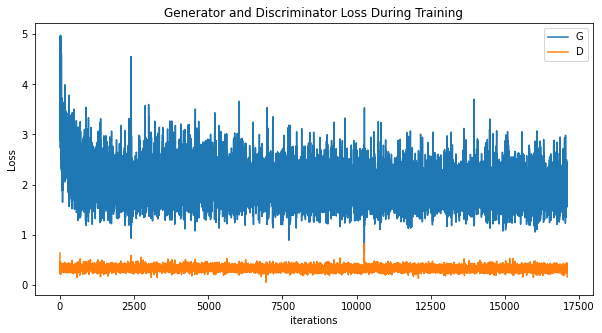

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Тестируем модель

In [ ]:
noise = torch.randn((1, 100, 1, 1), device=device)
# noise = torch.randint(0,256,(1, 100, 1, 1)).to(dtype=torch.float,device=device)

In [ ]:
test = oleg(noise)

In [ ]:
test.shape


torch.Size([1, 3, 100, 100])

(3, 100, 100)
(100, 100, 3)
[[[ 0.15924667  0.19746956  0.21417601]
  [ 0.11539271  0.14260949  0.16137926]
  [ 0.04741421  0.07371675  0.10135203]
  ...
  [ 0.28141242  0.32079774  0.2782489 ]
  [ 0.2758631   0.28298023  0.29204968]
  [ 0.27788517  0.25894746  0.23396687]]

 [[ 0.13359776  0.18779702  0.19283222]
  [ 0.00552671  0.05521032  0.13136543]
  [-0.01208743  0.02093615  0.10306396]
  ...
  [ 0.24604191  0.2679875   0.23625073]
  [ 0.21134385  0.24305625  0.23049486]
  [ 0.26215708  0.24652112  0.23078254]]

 [[ 0.07276503  0.14099242  0.16091636]
  [-0.02156163  0.0238524   0.06623067]
  [-0.077404    0.01115168  0.07294632]
  ...
  [ 0.17043726  0.20215446  0.20440401]
  [ 0.2186948   0.21021262  0.22592251]
  [ 0.24624519  0.2511669   0.22528176]]

 ...

 [[ 0.19658874  0.2279637   0.2505078 ]
  [ 0.17239752  0.21592255  0.25471416]
  [ 0.13011272  0.19540356  0.2413519 ]
  ...
  [ 0.21375698  0.34761703  0.34955007]
  [ 0.26238585  0.356973    0.36882085]
  [ 0.26821384  

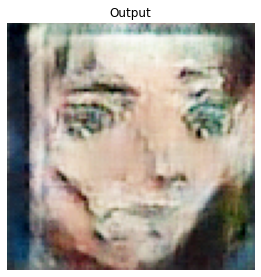

In [ ]:
figure(figsize=(13, 10))
plt.subplot(2, 2, 2) 
test = test.detach().to('cpu')

test = test.squeeze(0)
# print(test.detach().numpy())
test = test.numpy()
print(test.shape)
test = np.rollaxis(test,0, 3)
test = np.array(test, np.float32)
print(test.shape)
print(test)
# print(test)
# plt.imshow(test)
# print((test * 255).astype('uint8'))
plt.imshow(test)

plt.title('Output')
plt.axis('off')
plt.show()


In [ ]:
img_list[0].shape

torch.Size([10, 3, 100, 100])

In [ ]:
for i in range(0, 20, 5):
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(img_list[0].detach().to('cpu'), (2, 0, 1)))
    
    test = test.squeeze(0)
    # print(test.detach().numpy())
    test = test.numpy()
    print(test.shape)
    test = np.rollaxis(test,0, 3)
    test = np.array(test, np.float32)

    plt.show()

###Сохраним модель

In [ ]:
torch.save(oleg,'/content/drive/MyDrive/Deep learning /Gans по наруто лицам/NarutoGanUpdate.pt')

## Тестирование сохраненых моделей


In [41]:

oleg = torch.load('/content/drive/MyDrive/Deep learning /Gans по наруто лицам/NarutoGanUpdate.pt',map_location ='cpu') # 500 эпох и soft labels
oleg2 = oleg = torch.load('/content/drive/MyDrive/Deep learning /Gans по наруто лицам/NarutoGan.pt',map_location ='cpu') # 200 эпох
oleg.eval()
oleg2.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(7, 7), stride=(3, 3))
    (13): Tanh()
  )
)

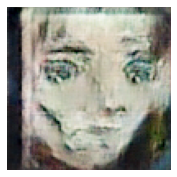

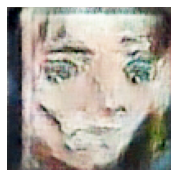

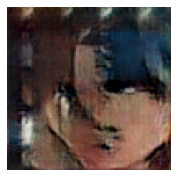

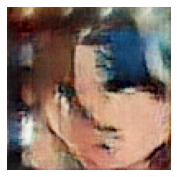

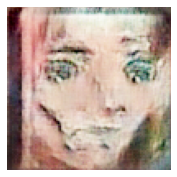

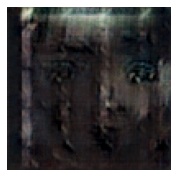

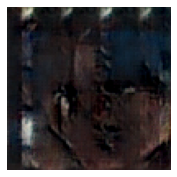

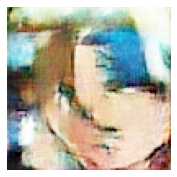

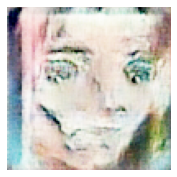

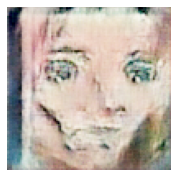

In [39]:
for i in range(0, 10):
    noise = torch.randn((1, 100, 1, 1))
    test = oleg.forward(noise)
    
    test = test.detach().to('cpu')
    test = test.squeeze(0)
    # print(test.detach().numpy())
    test = test.numpy()
    test = np.rollaxis(test,0, 3)
    test = np.array(test, np.float32)
    
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(test)
    plt.show()

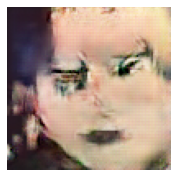

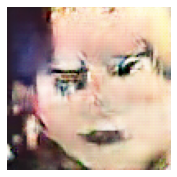

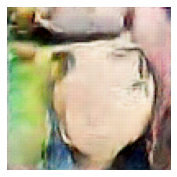

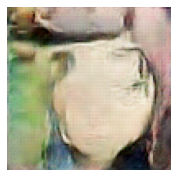

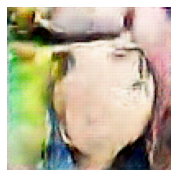

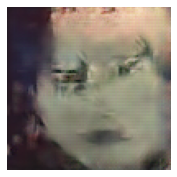

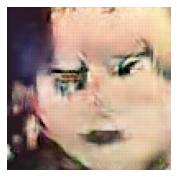

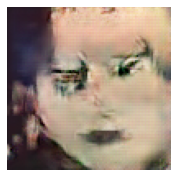

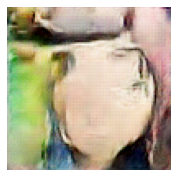

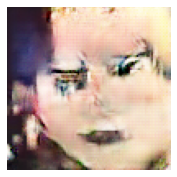

In [42]:
for i in range(0, 10):
    noise = torch.randn((1, 100, 1, 1))
    test = oleg2.forward(noise)
    
    test = test.detach().to('cpu')
    test = test.squeeze(0)
    # print(test.detach().numpy())
    test = test.numpy()
    test = np.rollaxis(test,0, 3)
    test = np.array(test, np.float32)
    
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(test)
    plt.show()

## Анализ результатов:

К сожалению нейросеть рисует только 3 типа лица с небольшими отличиями. Я думаю это из за того, что большинство картинок были одинаковыми и принадлежали только 3 персонажам(Наруто, Сакура, Гаара).

Чтобы улучшить сеть я считаю что нужно:
- увеличить датасет и разнообрзаить его
- поиграть с гиперпараметрами 
